# CUSTOMER SEGMENTATION AND RFM MODEL

- Customer segmentation is a method of dividing customers into groups or clusters on the basis of common characteristics.
- The market researcher can segment customers into the B2C model using various customer's demographic characteristics such as occupation, gender, age, location, and marital status.
- Psychographic characteristics such as social class, lifestyle and personality characteristics and behavioral characteristics such as spending, consumption habits, product/service usage, and previously purchased products.
- In the B2B model using various company's characteristics such as the size of the company, type of industry, and location.



**Why is it useful?**
- We can use it to group customers by the month of the first purchase, segment by their recency, frequency, and monetary values or run k-means clustering to identify similar groups of customers based on their purchasing behaviour
- By using this technique, marketers can identify which customers are the most valuable and tailor their marketing strategy accordingly

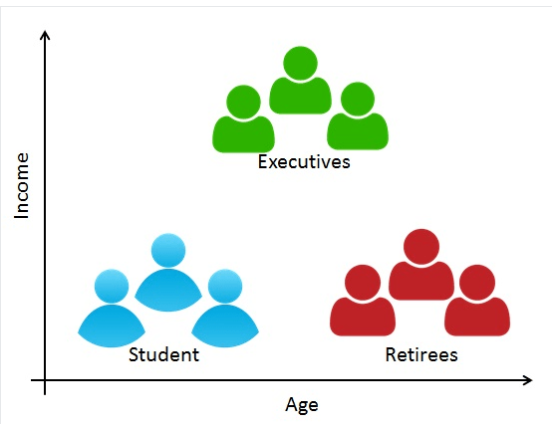

##**Cohort analysis**
- Groups customers into mutually exclusive cohorts which are then measured over time
- Helps with understanding the high lvl. trends by providing insights on metrics across both the product and customer lifecycle

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

## Observing the dataset

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df = df.sample(frac = 0.2) # Getting random 20% of the rows only
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
479580,577171,22593,CHRISTMAS GINGHAM STAR,12,2011-11-18 10:52:00,0.85,17159.0,United Kingdom
347356,567300,84997D,CHILDRENS CUTLERY POLKADOT PINK,4,2011-09-19 12:36:00,4.15,12724.0,France
319165,564841,23204,CHARLOTTE BAG APPLES DESIGN,9,2011-08-30 13:42:00,2.46,NaN,United Kingdom
81057,543108,84050,PINK HEART SHAPE EGG FRYING PAN,6,2011-02-03 12:37:00,1.65,14085.0,United Kingdom
88894,543821,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-02-14 09:24:00,0.55,17667.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108382 entries, 479580 to 398633
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    108382 non-null  object        
 1   StockCode    108382 non-null  object        
 2   Description  108087 non-null  object        
 3   Quantity     108382 non-null  int64         
 4   InvoiceDate  108382 non-null  datetime64[ns]
 5   UnitPrice    108382 non-null  float64       
 6   CustomerID   81297 non-null   float64       
 7   Country      108382 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 7.4+ MB


In [4]:
df.shape

(108382, 8)

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,108382.00000,108382.000000,81297.000000
mean,9.36817,4.908155,15291.495234
std,48.78927,108.859678,1711.699990
min,-9600.00000,0.000000,12347.000000
25%,1.00000,1.250000,13969.000000
50%,3.00000,2.100000,15152.000000
75%,10.00000,4.130000,16794.000000
max,2400.00000,17836.460000,18287.000000


In [6]:
df.Country.value_counts()

United Kingdom          99105
Germany                  1888
France                   1702
EIRE                     1694
Spain                     491
Netherlands               467
Switzerland               399
Belgium                   385
Portugal                  311
Australia                 264
Norway                    212
Channel Islands           163
Italy                     138
Cyprus                    131
Finland                   130
Denmark                    92
Unspecified                88
Austria                    83
Sweden                     82
Poland                     79
Israel                     72
Japan                      63
USA                        62
Hong Kong                  48
Singapore                  45
Greece                     34
Iceland                    31
Canada                     29
Malta                      19
European Community         15
RSA                        14
Lebanon                    12
United Arab Emirates        9
Lithuania 

- We can see that most of the customers are from the UK

**Duplicate values**

In [7]:
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"There are {duplicate_count} duplicate rows in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

There are 225 duplicate rows in the DataFrame.


In [8]:
df = df.drop_duplicates()

### Creating cohorts

In [9]:
# Defining useful functions
def get_month(x):
  """Truncates a given date object to a 1st day of the month and year"""
  first_day = dt.datetime(x.year, x.month, 1) # accesses the year, month, and the first day of the month
  return first_day


def get_date_int(df, column):
  """Extracts year, month, and day integer values from a given column"""
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

In [10]:
# Creating 2 new columns - InvoiceMonth, and CohortMonth
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
grouping = df.groupby("CustomerID")["InvoiceMonth"] # creates a series of the "InvoiceMonth" for each customer (each customer can have many invoices)
df["CohortMonth"] = grouping.transform("min") # assigns the smallest "InvoiceMonth" value to each customer (to get the first invoice of the customer)

In [11]:
# Calculating the nr. of months between each customer transaction and their first transaction
invoice_year, invoice_month, _ = get_date_int(df, "InvoiceMonth") # Gets the year and month integer values of each invoice (ignores the day)
cohort_year, cohort_month, _ = get_date_int(df, "CohortMonth")

years_dif = invoice_year - cohort_year
months_dif = invoice_month - cohort_month

df["CohortIndex"] = years_dif * 12 + months_dif + 1  # Getting the total difference in months

In [12]:
# Calculating the nr. of monthly active customers from each cohort
grouping = df.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique) # Counts the nr. of customers in each group
cohort_data = cohort_data.reset_index()

# Creating a pivot table
cohort_counts = cohort_data.pivot(index = "CohortMonth",
                                  columns = "CohortIndex",
                                  values = "CustomerID")

In [13]:
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,782.0,282.0,237.0,286.0,261.0,303.0,295.0,271.0,273.0,301.0,289.0,382.0,197.0
2011-01-01,395.0,88.0,105.0,90.0,135.0,105.0,104.0,99.0,124.0,130.0,147.0,56.0,NaN
2011-02-01,358.0,67.0,69.0,98.0,93.0,80.0,81.0,92.0,88.0,107.0,23.0,NaN,NaN
2011-03-01,422.0,64.0,97.0,83.0,96.0,74.0,110.0,96.0,115.0,34.0,NaN,NaN,NaN
2011-04-01,291.0,56.0,61.0,58.0,56.0,66.0,63.0,75.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,257.0,45.0,40.0,40.0,58.0,64.0,67.0,24.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,238.0,36.0,31.0,59.0,53.0,73.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,30.0,40.0,41.0,47.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,164.0,35.0,41.0,36.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating Metrics

**Retention rate** - Customer retention is a very useful metric to understand how many of all the customers are still active. It gives the % of active customers compared to the total nr. of customers

In [14]:
# Calculating the retention rates:
cohort_sizes = cohort_counts.iloc[:, 0] # Selecting the 1st column from the table
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention = retention.round(3) * 100
retention

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.1,30.3,36.6,33.4,38.7,37.7,34.7,34.9,38.5,37.0,48.8,25.2
2011-01-01,100.0,22.3,26.6,22.8,34.2,26.6,26.3,25.1,31.4,32.9,37.2,14.2,NaN
2011-02-01,100.0,18.7,19.3,27.4,26.0,22.3,22.6,25.7,24.6,29.9,6.4,NaN,NaN
2011-03-01,100.0,15.2,23.0,19.7,22.7,17.5,26.1,22.7,27.3,8.1,NaN,NaN,NaN
2011-04-01,100.0,19.2,21.0,19.9,19.2,22.7,21.6,25.8,6.9,NaN,NaN,NaN,NaN
2011-05-01,100.0,17.5,15.6,15.6,22.6,24.9,26.1,9.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.1,13.0,24.8,22.3,30.7,10.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,15.7,20.9,21.5,24.6,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.3,25.0,22.0,13.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- The first column has 100% retention rate for all cohorts as expected

In [15]:
# Calculating the average quantities purchased:
grouping = df.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["Quantity"].mean()
cohort_data = cohort_data.reset_index()
avg_quantity = cohort_data.pivot(index = "CohortMonth",
                                     columns = "CohortIndex",
                                     values = "Quantity")
avg_quantity = avg_quantity.round(1)
avg_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,10.7,15.2,14.3,14.2,11.7,12.9,13.2,11.6,15.2,15.1,17.5,11.9,12.1
2011-01-01,10.9,15.0,16.7,9.3,14.1,15.7,13.7,17.5,13.7,10.0,9.9,12.1,NaN
2011-02-01,12.1,10.3,12.1,10.5,16.4,8.7,11.4,14.1,10.6,18.0,9.3,NaN,NaN
2011-03-01,11.6,16.8,12.2,12.8,19.2,12.4,15.2,14.9,11.8,17.6,NaN,NaN,NaN
2011-04-01,9.7,10.1,10.0,11.3,15.3,8.8,9.1,10.4,8.1,NaN,NaN,NaN,NaN
2011-05-01,9.4,7.9,14.0,14.8,11.9,8.6,9.8,7.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,12.6,9.9,13.8,11.0,7.8,8.6,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,17.0,9.3,9.9,6.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.8,5.6,5.6,5.9,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating cohort visualisation

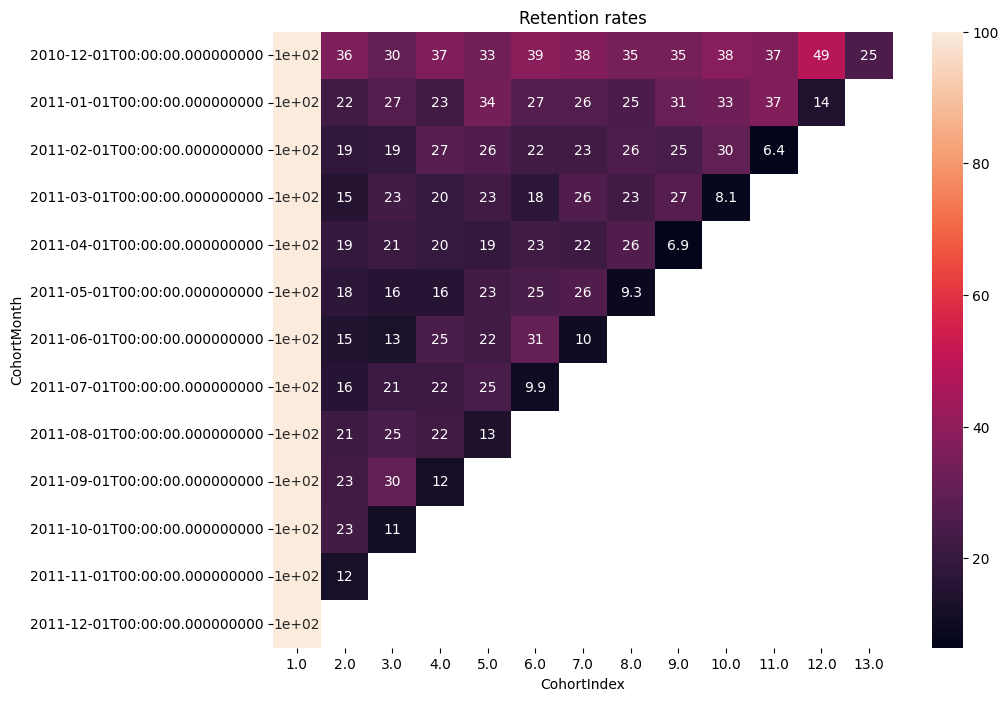

In [16]:
plt.figure(figsize = (10, 8))
plt.title("Retention rates")
sns.heatmap(data = retention, annot = True)
plt.show()

## RFM Segmentation analysis

We need 3 customer behaviour metrics:
- 1) **Recency (R)** - Measures how recent was each customer´s last purchase - The lower it is, the better (= nr. of days since last customer transactions)
- 2) **Frequency (F)** - Measures how many purchases the customer has done in the last 12 months - The higher it is, the better (= nr. of transactions in the last 12 mths)
- 3) **Monetery value (M)** - Measures how much has the customer spent in the last 12 months - The higher it is, the better

We will use these 3 metrics to assign customers to RFM segments and we will then group them in certain groups

**This grouping can be done in several ways:**
- Break the customers into groups of equal size based on percentile values of each metric
- Assigning high/low value to each metric based on the 80/20 % Pareto split
- Using existing knowledge from previous business insights about certain threshold values for each metric

We need to preprocess the dataframe so that is only includes the most recent 12 mths of data (the most recent snapshot of data from today)

In [17]:
print("Min:{}; Max:{}".format(min(df.InvoiceDate),
                              max(df.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


The data starts from 2010 so we have to create a hypothetical snapshot data that we will use as a starting point to calculate metrics as if we are doing analysis on the most recent data

In [18]:
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days = 1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

- So we have the snapshot date and the last 12 months most recently available

#### Calculating the RFM values

In [19]:
df["TotalSum"] = df["UnitPrice"] * df["Quantity"]

In [20]:
# Calculating the RFM Metrics:
datamart = df.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda date: (snapshot_date - date.max()).days,  # The nr. of days between the hypothetical today and the last transaction
    "InvoiceNo": "count",
    "TotalSum": "sum"})

# Renaming the columns:
datamart.rename(columns = {"InvoiceDate": "Recency", # Nr. of days since last customer transaction
                           "InvoiceNo": "Frequency", # Nr. of products purchased in last 12 mths
                           "TotalSum": "MonetaryValue"}, inplace = True) # Total spending in last 12 mths

datamart.head(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,2,31,589.83
12348.0,75,5,137.68
12349.0,19,21,736.32
12350.0,310,4,65.10
12352.0,36,19,680.37


We will now group customers into 4 segments of the same size for each RFM value

#### Calculating the RFM quartiles

In [21]:
# Creating Recency quartiles (recency is better low)
r_labels = range(4, 0, -1) # We will rate customers who have been active more recently better than the less recent customers
r_quartiles = pd.qcut(datamart["Recency"], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

# Creating Frequency quartiles (frequency is better high - so we assign higher labels to higher values)
f_labels = range(1, 5)
f_quartiles = pd.qcut(datamart["Frequency"], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartiles.values)

# Creating Monetary value quartiles (Monetary value is better high - so we assign higher labels to higher values)
m_labels = range(1, 5)
m_quartiles = pd.qcut(datamart["MonetaryValue"], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

In [22]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12347.0,2,31,589.83,4,4,4
12348.0,75,5,137.68,2,2,2
12349.0,19,21,736.32,3,3,4
12350.0,310,4,65.10,1,1,2
12352.0,36,19,680.37,3,3,4
...,...,...,...,...,...,...
18278.0,74,3,61.70,2,1,2
18280.0,278,2,32.70,1,1,1
18282.0,8,3,32.85,4,1,1


- So now all customers have a quartile value assigned that we will use to build the segmentation

**RFM Segment** = Concatenated string of RFM values

**RFM Score** = Sum of RFM values



In [23]:
# Creating the RFM Segment
to_convert = ["R", "F", "M"]
datamart[to_convert] = datamart[to_convert].apply(pd.to_numeric, errors = "coerce").fillna(0).astype(int)

def join_rfm(x):
  """Creates a concatenated list of RFM values converted to strings"""
  joined_rfm = str(x["R"]) + str(x["F"]) + str(x["M"])
  return joined_rfm

datamart["RFM_Segment"] = datamart.apply(join_rfm, axis = 1)

# Creating the RFM Score
datamart["RFM_Score"] = datamart[["R", "F", "M"]].sum(axis = 1)

In [24]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,31,589.83,4,4,4,4.04.04.0,12
12348.0,75,5,137.68,2,2,2,2.02.02.0,6
12349.0,19,21,736.32,3,3,4,3.03.04.0,10
12350.0,310,4,65.10,1,1,2,1.01.02.0,4
12352.0,36,19,680.37,3,3,4,3.03.04.0,10
...,...,...,...,...,...,...,...,...
18278.0,74,3,61.70,2,1,2,2.01.02.0,5
18280.0,278,2,32.70,1,1,1,1.01.01.0,3
18282.0,8,3,32.85,4,1,1,4.01.01.0,6


#### Analyzing the RFM Segments

In [25]:
# Observing the largest 10 RFM Segments
datamart.groupby("RFM_Segment").size().sort_values(ascending = False)[:10]

RFM_Segment
4.04.04.0    416
1.01.01.0    378
3.04.04.0    204
2.01.01.0    194
2.03.03.0    162
3.03.03.0    141
4.03.03.0    140
1.02.02.0    138
2.02.02.0    135
3.01.01.0    134
dtype: int64

- The highest rated RFM Segment (444) has the most amount of customers = 414
- The lowest rated RFM segment (111) has the 2nd most amount of customers = 374

In [26]:
datamart.groupby("RFM_Score").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           257.1       2.1          20.7   378
4           171.0       3.2          44.4   393
5           143.6       4.7          68.9   467
6           102.1       6.2         205.3   435
7            82.2       8.4         166.6   418
8            65.7      12.9         221.3   475
9            47.6      17.6         316.2   359
10           32.2      24.5         408.3   410
11           21.7      41.6         859.9   351
12            7.4      80.7        1878.8   416

We often group the customers based on their RFM score into an even smaller nr. of segments

In [27]:
def segment_me(df):
  if df["RFM_Score"] >= 9:
    return "Gold"
  elif (df["RFM_Score"] >= 5) and (df["RFM_Score"] < 9):
    return "Silver"
  else:
    return "Bronze"

datamart["General_Segment"] = datamart.apply(segment_me, axis = 1)
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12347.0,2,31,589.83,4,4,4,4.04.04.0,12,Gold
12348.0,75,5,137.68,2,2,2,2.02.02.0,6,Silver
12349.0,19,21,736.32,3,3,4,3.03.04.0,10,Gold
12350.0,310,4,65.10,1,1,2,1.01.02.0,4,Bronze
12352.0,36,19,680.37,3,3,4,3.03.04.0,10,Gold
...,...,...,...,...,...,...,...,...,...
18278.0,74,3,61.70,2,1,2,2.01.02.0,5,Silver
18280.0,278,2,32.70,1,1,1,1.01.01.0,3,Bronze
18282.0,8,3,32.85,4,1,1,4.01.01.0,6,Silver


In [28]:
datamart.groupby("General_Segment").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            213.2       2.7          32.8   771
Gold               26.7      42.0         888.2  1536
Silver             98.6       8.1         165.1  1795

# Data Preprocessing for K-Means clustering

### K-Means Critical Assumptions

- 1) All variables must have symmetrical distributions (not skewed)
- 2) All variables have the same average/mean values
- 3) All variables must have the same variance

**Dealing with negative values** - The simplest way is to add a constant value to each variable (např. the absolute value of the lowest negative value to each observation and then a small constant like 1 to force the variables to be strictly positive)

**Note** - Luckily, customer behaviour data is almost always positive so we do not have to worry about this

However, here some of the monetary values are negative so we can just remove these

In [29]:
datamart["MonetaryValue"].sort_values().head(50)

CustomerID
12503.0   -1126.00
17603.0    -947.99
12669.0    -906.53
12757.0    -641.76
15802.0    -451.42
16742.0    -428.40
13564.0    -348.29
13984.0    -247.98
18133.0    -216.00
18087.0    -163.20
15823.0    -140.70
17548.0    -103.32
13829.0    -102.00
14557.0     -93.40
15257.0     -85.00
12504.0     -81.95
15100.0     -76.65
12908.0     -72.00
16252.0     -61.17
15638.0     -60.00
17152.0     -49.60
14475.0     -43.44
18072.0     -42.24
12607.0     -42.04
13672.0     -35.04
15728.0     -34.50
13364.0     -33.60
15590.0     -30.19
14501.0     -26.10
13958.0     -25.50
16546.0     -23.46
15729.0     -23.00
16262.0     -19.90
18256.0     -19.55
12403.0     -18.00
17900.0     -15.00
12929.0     -12.75
17010.0      -9.90
14460.0      -9.24
15922.0      -5.90
15881.0      -5.26
14627.0      -4.95
12505.0      -4.50
16498.0      -3.91
13217.0      -3.40
16878.0      -2.55
16690.0      -1.95
12605.0      -1.65
16124.0      -1.35
16217.0      -0.70
Name: MonetaryValue, dtype: float64

In [30]:
# Getting rid of the negative monetary values
datamart = datamart[datamart["MonetaryValue"] > 0]

**How to identify skewed variables?** - by looking at each variable´s distribution

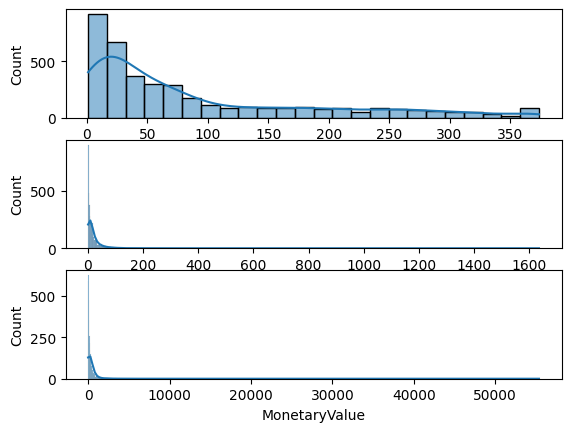

In [31]:
# Recency distribution
plt.subplot(3, 1, 1)
sns.histplot(datamart["Recency"], kde = True)

# Frequency distribution
plt.subplot(3, 1, 2)
sns.histplot(datamart["Frequency"], kde = True)

# Monetary value distribution
plt.subplot(3, 1, 3)
sns.histplot(datamart["MonetaryValue"], kde = True)

plt.show()

- We can see there is a heavy right skew for Frequency and Monetary value and a small right skew for Recency as well

**1) How to unskew the data?** - By appling Logarithmic Transformation = but this only works on positive values!!!!!!

In [32]:
# Only getting the 3 columns we need:
datamart_rfm = datamart[["Recency", "Frequency", "MonetaryValue"]]
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4048.000000,4048.000000,4048.000000
mean,91.916502,19.960474,418.185010
std,98.465772,48.775654,1740.173443
min,1.000000,1.000000,0.400000
25%,18.000000,4.000000,58.020000
50%,51.000000,9.000000,140.785000
75%,142.000000,21.000000,341.980000
max,374.000000,1635.000000,55367.870000


In [33]:
# Appling log transformation:
datamart_rfm_log = np.log(datamart_rfm)

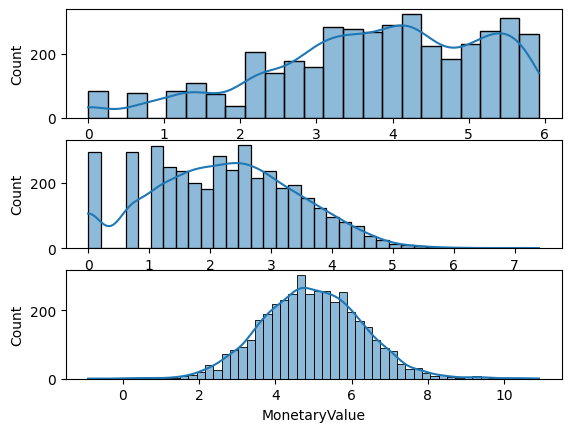

In [34]:
plt.subplot(3, 1, 1)
sns.histplot(datamart_rfm_log["Recency"], kde = True)

plt.subplot(3, 1, 2)
sns.histplot(datamart_rfm_log["Frequency"], kde = True)

plt.subplot(3, 1, 3)
sns.histplot(datamart_rfm_log["MonetaryValue"], kde = True)

plt.show()

**2) + 3) Centering variables with different means and different variances**

In [35]:
ss = StandardScaler()
ss.fit(datamart_rfm_log)
datamart_normalised = ss.transform(datamart_rfm_log)

print("mean: ", datamart_normalised.mean(axis = 0).round(2))
print("std: ", datamart_normalised.std(axis = 0).round(2))

mean:  [-0.  0.  0.]
std:  [1. 1. 1.]


- We can see that now the means and variances are the same which is what we wanted

**Note:**

datamart_rfm = raw data

datamart_normalised = preprocessed data

### Applying K-Means Clustering

- we need to decide on the nr. of clusters (Elbow method)

In [36]:
random_state = 42
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state = random_state)
kmeans.fit(datamart_normalised)
cluster_labels = kmeans.labels_

Analysing how these clusters differ from each other by using the raw data:

In [37]:
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a Cluster column which has cluster labels as the values to the datamart_rfm dataframe
datamart_rfm_k2

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,2,31,589.83,0
12348.0,75,5,137.68,1
12349.0,19,21,736.32,0
12350.0,310,4,65.10,1
12352.0,36,19,680.37,0
...,...,...,...,...
18278.0,74,3,61.70,1
18280.0,278,2,32.70,1
18282.0,8,3,32.85,1


In [38]:
datamart_rfm_k2.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          32.0      37.5         812.7  1824
1         141.1       5.5          94.6  2224

- Cluster 1 has customers who have not been very recent, are less frequent with their puchases and the monetary values are also way lower than those of Cluster 0

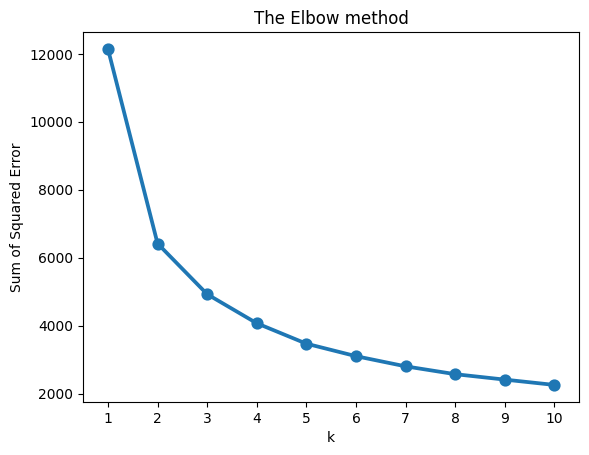

In [39]:
# Elbow criterion method
sse = {}
for k in range(1, 11): # Trying different nr. of clusters from 1 to 10
  kmeans = KMeans(n_clusters = k, random_state = random_state)
  kmeans.fit(datamart_normalised)
  sse[k] = kmeans.inertia_ # Sum of squared error

# Plotting it
plt.title("The Elbow method")
plt.xlabel("k")
plt.ylabel("Sum of Squared Error")
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

- We are looking for the largest angle (here např. number 4 looks like it)
- We can experiment and be advised with the business to see which solution makes the most sense (how many clusters they are looking for)

**How to profile and interpret the segments**
- Using snake plots = chart that visualises RFM values between the segments
- Calculating relative importance of cluster attrributes compared to the population average

Firstly when we use 2 clusters:

In [40]:
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a column "Cluster" to the datamart_rfm dataframe

datamart_rfm_k2.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          32.0      38.0         813.0  1824
1         141.0       6.0          95.0  2224

Now combining it to when we use 3 clusters:

In [41]:
random_state = 42
kmeans3 = KMeans(n_clusters = 3, random_state = random_state)
kmeans3.fit(datamart_normalised)
cluster_labels = kmeans3.labels_

datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a column "Cluster" to the datamart_rfm dataframe

datamart_rfm_k3.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         167.0       3.0          57.0  1370
1          74.0      14.0         253.0  1756
2          15.0      56.0        1269.0   922

**Using Snake plots**

In [42]:
# Transforming datamart_normalised as a Pandas DataFrame
datamart_normalised = pd.DataFrame(datamart_normalised,
                                   index = datamart_rfm.index,
                                   columns = datamart_rfm.columns)
datamart_normalised["Cluster"] = datamart_rfm_k3["Cluster"]

# Melting the dataset into a long format for easier plotting
datamart_melt = pd.melt(datamart_normalised.reset_index(),
                        id_vars = ["CustomerID", "Cluster"],
                        value_vars = ["Recency", "Frequency", "MonetaryValue"],
                        var_name = "Attribute",
                        value_name = "Value")

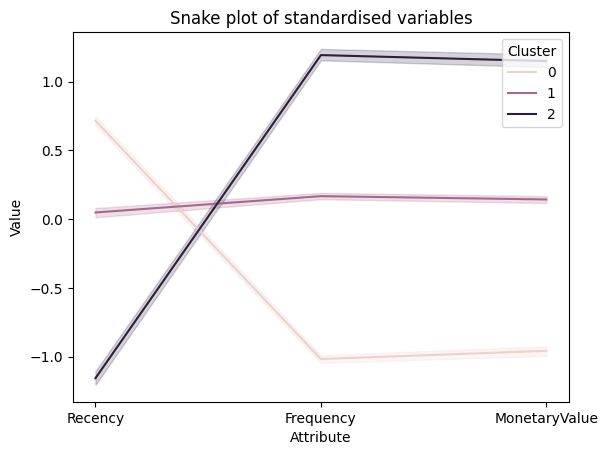

In [43]:
# Visualising the snake plot:
plt.title("Snake plot of standardised variables")
sns.lineplot(x = "Attribute", y = "Value", hue = "Cluster", data = datamart_melt)
plt.show()

**Identifying relative importance of segment attributes**

In [44]:
# Calculating the relative importance score for each RFM value of the segments
cluster_avg = datamart_rfm_k3.groupby(["Cluster"]).mean()
population_avg = datamart_rfm.mean()
relative_imp = (cluster_avg / population_avg) - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.82,-0.83,-0.86
1,-0.20,-0.31,-0.39
2,-0.84,1.82,2.03


- The further the ratio is from zero, the more important that attribute is for defining a specific cluster compared to the population average

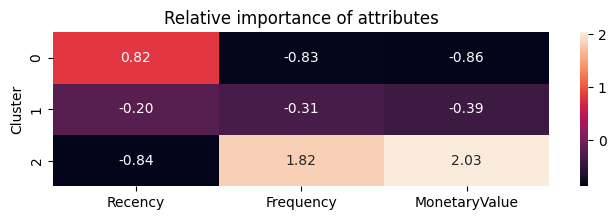

In [45]:
 # Visualising it through a heatmap
 plt.figure(figsize = (8, 2))
 plt.title("Relative importance of attributes")
 sns.heatmap(data = relative_imp, annot = True, fmt = ".2f")
 plt.show()